# LSTM: Hoe AI leert onthouden en vergeten

Stel je voor: je leest een boek en halverwege hoofdstuk 5 staat:

> "Hij pakte het wapen dat hij drie hoofdstukken eerder had verstopt"

Als mens kun je dit begrijpen omdat je **onthoudt** wat je eerder las. Maar hoe doet AI dat?

**LSTMs (Long Short-Term Memory)** zijn neurale netwerken met een geheugen. Ze kunnen:
- Belangrijke dingen **onthouden** voor later
- Onbelangrijke dingen **vergeten**
- Zelf beslissen wat belangrijk is

In dit notebook leer je hoe LSTMs werken zonder ingewikkelde wiskunde - gewoon met heldere uitleg en voorbeelden.

---
**Instructie:** Voer iedere cel uit met **Shift+Enter**

## Het probleem: Normale netwerken vergeten alles

Een gewoon neuraal netwerk heeft **geen geheugen**. Het is alsof je steeds je korte-termijn geheugen verliest:

```
Je leest: "De kat"
Netwerk denkt: "Ok, een kat"

Je leest: "zat op"
Netwerk denkt: "Iets zat ergens" (vergeten wat!)

Je leest: "de mat"
Netwerk denkt: "Een mat" (vergeten dat de kat erop zat!)
```

**Met een LSTM:**
```
Je leest: "De kat"
LSTM: "Onthoud: kat (onderwerp)"

Je leest: "zat op"
LSTM: "Onthoud: kat + zitten" 

Je leest: "de mat"
LSTM: "Aha! De kat zat op de mat" ✓
```

## LSTM als een slim notitieboek

Stel je voor dat een LSTM een **student is die aantekeningen maakt** tijdens een college:

### De drie beslissingen:

1. **Forget Gate (Wegstrepen)** 
   - "Deze info is niet meer relevant" → streep het door
   - Voorbeeld: Professor zegt "Vergeet wat ik net zei, dat was fout"

2. **Input Gate (Nieuwe notities)**
   - "Dit is belangrijk!" → schrijf het op
   - Voorbeeld: Professor zegt "Dit komt op het tentamen"

3. **Output Gate (Delen)**
   - "Dit moet ik nu delen met mijn studiegroep"
   - Je hoeft niet alles wat je weet meteen te delen

### Het notitieboek zelf:
- **Cell State** = je notitieboek met alle aantekeningen (lange termijn)
- **Hidden State** = wat je nu zegt tegen je studiegroep (korte termijn)

Dit is precies hoe een LSTM werkt!

In [1]:
# Setup voor visualisaties
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

print("Klaar om LSTM visueel te verkennen!")

Klaar om LSTM visueel te verkennen!


## De anatomie van een LSTM

Een LSTM heeft vier hoofdcomponenten:

```
                     Cell State (het geheugen)
                    ─────────────────────────→
                           │        │
    Input → [Forget Gate] [Input Gate] [Output Gate] → Output
                 │             │            │
              Vergeten?    Onthouden?    Delen?
```

Laten we elk onderdeel apart bekijken.

## 1. Forget Gate: Wat mogen we vergeten?

**Analogie:** Je leest een verhaal en de hoofdpersoon verandert.

```
"Anna liep door het park. Zij was moe.
 Ondertussen was Peter thuis. Hij kookte eten."
```

Bij "Peter" moet je **vergeten** dat het verhaal over Anna ging, anders denk je dat Peter moe is.

**Hoe werkt het?**
- De Forget Gate geeft voor elk stukje geheugen een score tussen 0 en 1:
  - **0 = volledig vergeten** ("Anna is niet meer relevant")
  - **1 = volledig onthouden** ("De locatie 'park' is nog steeds belangrijk")
  - **0.5 = half vergeten** ("Misschien nog een beetje relevant")

C:\Users\sybra\AppData\Local\Temp\ipykernel_34680\3008678300.py:58: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\sybra\OneDrive\Bureaublad\neural_nets\neural_networks_training_advanced_ai\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


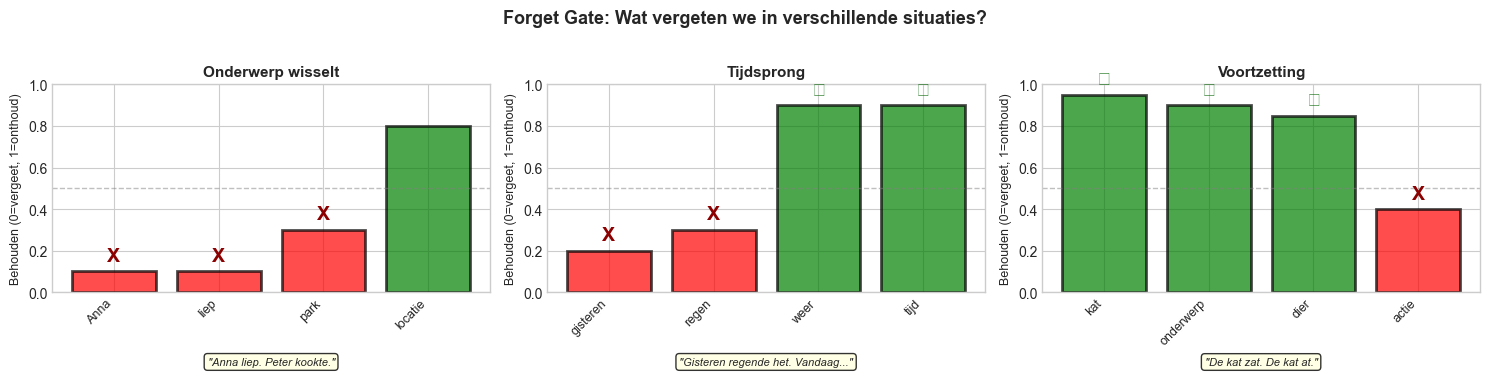


Interpretatie:
- ROOD (< 0.5): Deze info wordt grotendeels vergeten
- ORANJE (0.5-0.7): Gedeeltelijk behouden
- GROEN (> 0.7): Deze info wordt goed onthouden


In [2]:
# Visualiseer het vergeetproces

def toon_forget_gate_scenario():
    scenarios = [
        {
            'titel': 'Onderwerp wisselt',
            'context': '"Anna liep. Peter kookte."',
            'geheugen': ['Anna', 'liep', 'park', 'locatie'],
            'forget': [0.1, 0.1, 0.3, 0.8],  # Vergeet Anna, behoud locatie
            'uitleg': 'Anna is niet meer relevant, maar locatie wel'
        },
        {
            'titel': 'Tijdsprong',
            'context': '"Gisteren regende het. Vandaag..."',
            'geheugen': ['gisteren', 'regen', 'weer', 'tijd'],
            'forget': [0.2, 0.3, 0.9, 0.9],  # Vergeet specifieke dag, behoud algemeen
            'uitleg': 'Specifieke details vergeten, context behouden'
        },
        {
            'titel': 'Voortzetting',
            'context': '"De kat zat. De kat at."',
            'geheugen': ['kat', 'onderwerp', 'dier', 'actie'],
            'forget': [0.95, 0.9, 0.85, 0.4],  # Behoud onderwerp
            'uitleg': 'Onderwerp blijft hetzelfde, actie verandert'
        }
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, scenario in enumerate(scenarios):
        ax = axes[idx]
        
        forget_vals = scenario['forget']
        colors = ['red' if f < 0.5 else 'orange' if f < 0.7 else 'green' for f in forget_vals]
        
        bars = ax.bar(range(len(forget_vals)), forget_vals, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
        ax.set_ylim(0, 1)
        ax.set_title(scenario['titel'], fontweight='bold', fontsize=11)
        ax.set_ylabel('Behouden (0=vergeet, 1=onthoud)', fontsize=9)
        ax.set_xticks(range(len(scenario['geheugen'])))
        ax.set_xticklabels(scenario['geheugen'], rotation=45, ha='right', fontsize=9)
        ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        
        # Annotaties
        for i, (bar, val) in enumerate(zip(bars, forget_vals)):
            if val < 0.5:
                ax.text(i, val + 0.05, 'X', ha='center', fontsize=14, color='darkred', fontweight='bold')
            elif val > 0.8:
                ax.text(i, val + 0.05, '✓', ha='center', fontsize=14, color='darkgreen', fontweight='bold')
        
        # Context box
        ax.text(0.5, -0.35, scenario['context'], ha='center', fontsize=8, 
                transform=ax.transAxes, style='italic',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.suptitle('Forget Gate: Wat vergeten we in verschillende situaties?', 
                 fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretatie:")
    print("- ROOD (< 0.5): Deze info wordt grotendeels vergeten")
    print("- ORANJE (0.5-0.7): Gedeeltelijk behouden")
    print("- GROEN (> 0.7): Deze info wordt goed onthouden")

toon_forget_gate_scenario()

## 2. Input Gate: Wat moeten we onthouden?

**Analogie:** Je kijkt het journaal. Sommige dingen zijn belangrijk, andere niet.

```
Nieuwslezer: "Het weer wordt morgen regenachtig." → BELANGRIJK!
Nieuwslezer: "Dit item werd gesponsord door..." → Niet zo belangrijk
```

**Hoe werkt het?**
1. Nieuwe informatie komt binnen
2. De Input Gate besluit: "Hoe belangrijk is dit?"
3. Alleen belangrijke info wordt toegevoegd aan het geheugen

**Twee stappen:**
- **Stap 1:** Wat is de nieuwe informatie? (de kandidaat)
- **Stap 2:** Hoeveel daarvan laten we door? (de filter)

C:\Users\sybra\AppData\Local\Temp\ipykernel_34680\1577413237.py:61: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\sybra\OneDrive\Bureaublad\neural_nets\neural_networks_training_advanced_ai\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


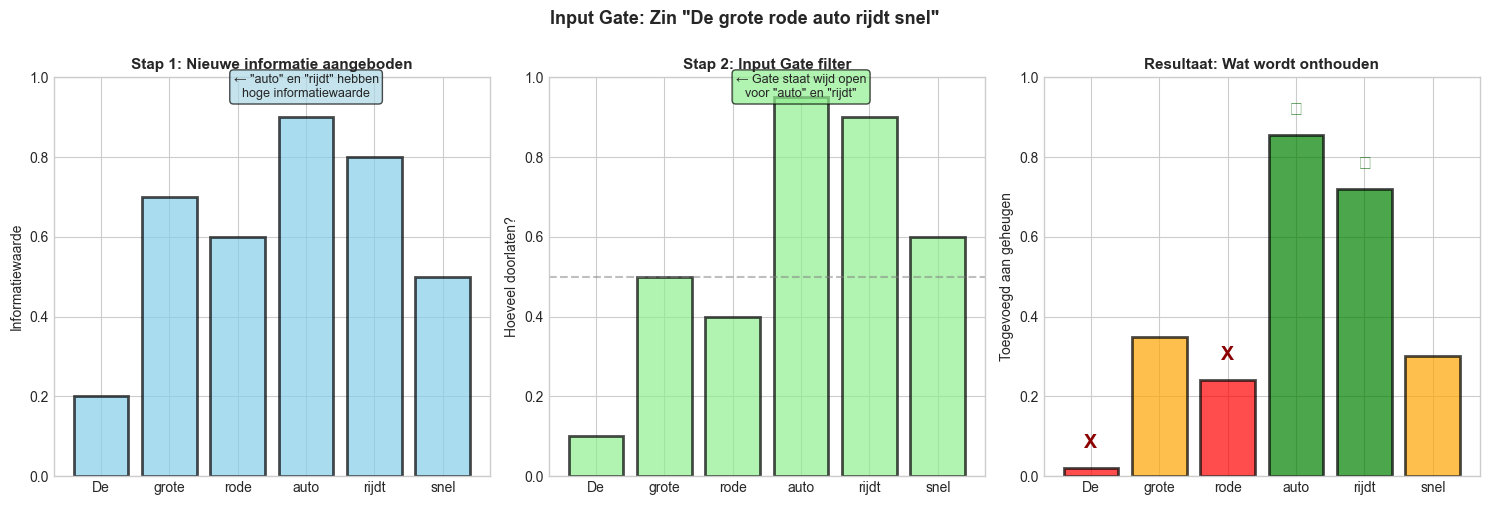


Wat wordt onthouden?
  'De': 0.02 → GENEGEERD
  'grote': 0.35 → DEELS
  'rode': 0.24 → GENEGEERD
  'auto': 0.85 → ONTHOUDEN
  'rijdt': 0.72 → ONTHOUDEN
  'snel': 0.30 → DEELS

Conclusie: 'auto' en 'rijdt' zijn de belangrijkste woorden!


In [3]:
# Visualiseer de Input Gate

def toon_input_gate_filtering():
    # Scenario: We lezen een zin en beslissen wat belangrijk is
    woorden = ['De', 'grote', 'rode', 'auto', 'rijdt', 'snel']
    
    # Nieuwe informatie (kandidaten) - wat biedt elk woord aan?
    nieuwe_info_waarde = [0.2, 0.7, 0.6, 0.9, 0.8, 0.5]
    
    # Input gate filter - hoe belangrijk is elk woord?
    input_gate_filter = [0.1, 0.5, 0.4, 0.95, 0.9, 0.6]
    
    # Wat wordt daadwerkelijk toegevoegd?
    toegevoegd = [nw * ig for nw, ig in zip(nieuwe_info_waarde, input_gate_filter)]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    x = np.arange(len(woorden))
    
    # Grafiek 1: Kandidaat informatie
    axes[0].bar(x, nieuwe_info_waarde, color='skyblue', alpha=0.7, edgecolor='black', linewidth=2)
    axes[0].set_title('Stap 1: Nieuwe informatie aangeboden', fontweight='bold', fontsize=11)
    axes[0].set_ylabel('Informatiewaarde', fontsize=10)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(woorden, fontsize=10)
    axes[0].set_ylim(0, 1)
    axes[0].text(3, 0.95, '← "auto" en "rijdt" hebben\nhoge informatiewaarde', 
                ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    # Grafiek 2: Filter (hoe ver staat de gate open?)
    axes[1].bar(x, input_gate_filter, color='lightgreen', alpha=0.7, edgecolor='black', linewidth=2)
    axes[1].set_title('Stap 2: Input Gate filter', fontweight='bold', fontsize=11)
    axes[1].set_ylabel('Hoeveel doorlaten?', fontsize=10)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(woorden, fontsize=10)
    axes[1].set_ylim(0, 1)
    axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    axes[1].text(3, 0.95, '← Gate staat wijd open\nvoor "auto" en "rijdt"', 
                ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    # Grafiek 3: Resultaat
    colors = ['red' if t < 0.3 else 'orange' if t < 0.6 else 'green' for t in toegevoegd]
    axes[2].bar(x, toegevoegd, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    axes[2].set_title('Resultaat: Wat wordt onthouden', fontweight='bold', fontsize=11)
    axes[2].set_ylabel('Toegevoegd aan geheugen', fontsize=10)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(woorden, fontsize=10)
    axes[2].set_ylim(0, 1)
    
    # Markeer belangrijke woorden
    for i, val in enumerate(toegevoegd):
        if val > 0.6:
            axes[2].text(i, val + 0.05, '✓', ha='center', fontsize=14, 
                        color='darkgreen', fontweight='bold')
        elif val < 0.3:
            axes[2].text(i, val + 0.05, 'X', ha='center', fontsize=14, 
                        color='darkred', fontweight='bold')
    
    plt.suptitle('Input Gate: Zin "De grote rode auto rijdt snel"', 
                 fontsize=13, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    
    print("\nWat wordt onthouden?")
    print("="*50)
    for woord, val in zip(woorden, toegevoegd):
        status = "ONTHOUDEN" if val > 0.6 else "GENEGEERD" if val < 0.3 else "DEELS"
        print(f"  '{woord}': {val:.2f} → {status}")
    print("\nConclusie: 'auto' en 'rijdt' zijn de belangrijkste woorden!")

toon_input_gate_filtering()

## 3. Cell State Update: Het geheugen updaten

Nu combineren we de twee vorige stappen:

**Analogie:** Je notitieboek updaten tijdens een college.

```
Oud notitieboek: "Hoofdstuk 3 gaat over fotosynthese"
                              ↓
Forget Gate: "Streep fotosynthese door" (nieuw onderwerp!)
                              ↓
Input Gate: "Schrijf op: Hoofdstuk 4 gaat over mitose"
                              ↓
Nieuw notitieboek: "Hoofdstuk 4 gaat over mitose"
```

**De formule (in woorden):**
```
Nieuw geheugen = (Oud geheugen × Wat we onthouden) + (Nieuwe info × Wat we toevoegen)
```

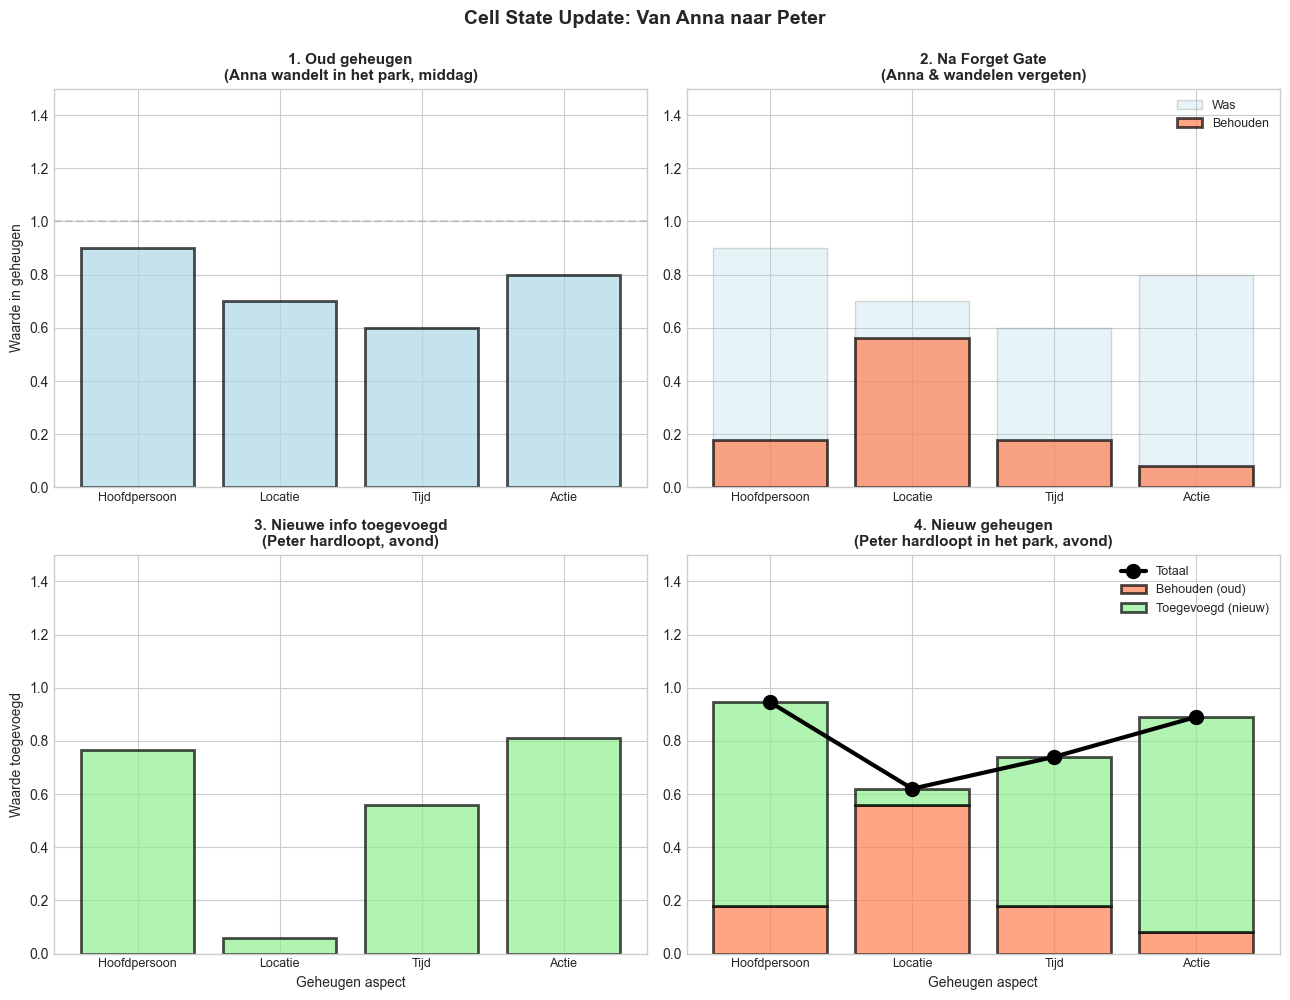


Transitie in het verhaal:
OUD: Anna wandelt in het park, middag
↓
FORGET: Anna en 'wandelen' niet meer relevant
INPUT: Peter, 'hardlopen', en 'avond' zijn nieuw
↓
NIEUW: Peter hardloopt in het park (nog steeds), avond

Het park blijft behouden - de rest is geüpdatet!


In [4]:
# Visualiseer geheugen update

def toon_geheugen_update():
    # Scenario: We lezen een verhaal
    geheugen_aspecten = ['Hoofdpersoon', 'Locatie', 'Tijd', 'Actie']
    
    # Stap 1: Oud geheugen
    oud_geheugen = np.array([0.9, 0.7, 0.6, 0.8])  # Anna, park, middag, wandelen
    
    # Stap 2: Forget gate (nieuw hoofdstuk over Peter begint!)
    forget = np.array([0.2, 0.8, 0.3, 0.1])  # Vergeet Anna & actie, behoud locatie
    behouden = oud_geheugen * forget
    
    # Stap 3: Nieuwe info
    nieuwe_info = np.array([0.85, 0.3, 0.7, 0.9])  # Peter, -, avond, hardlopen
    input_gate = np.array([0.9, 0.2, 0.8, 0.9])   # Onthoud nieuwe hoofdpersoon!
    toegevoegd = nieuwe_info * input_gate
    
    # Stap 4: Nieuw geheugen
    nieuw_geheugen = behouden + toegevoegd
    
    # Visualisatie
    fig, axes = plt.subplots(2, 2, figsize=(13, 10))
    
    x = np.arange(len(geheugen_aspecten))
    
    # Plot 1: Oud geheugen
    axes[0, 0].bar(x, oud_geheugen, color='lightblue', alpha=0.7, edgecolor='black', linewidth=2)
    axes[0, 0].set_title('1. Oud geheugen\n(Anna wandelt in het park, middag)', 
                         fontweight='bold', fontsize=11)
    axes[0, 0].set_ylim(0, 1.5)
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(geheugen_aspecten, fontsize=9)
    axes[0, 0].set_ylabel('Waarde in geheugen', fontsize=10)
    axes[0, 0].axhline(y=1.0, color='gray', linestyle='--', alpha=0.3)
    
    # Plot 2: Na Forget Gate
    axes[0, 1].bar(x, oud_geheugen, color='lightblue', alpha=0.3, label='Was', edgecolor='gray', linewidth=1)
    axes[0, 1].bar(x, behouden, color='coral', alpha=0.7, label='Behouden', edgecolor='black', linewidth=2)
    axes[0, 1].set_title('2. Na Forget Gate\n(Anna & wandelen vergeten)', 
                         fontweight='bold', fontsize=11)
    axes[0, 1].set_ylim(0, 1.5)
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(geheugen_aspecten, fontsize=9)
    axes[0, 1].legend(loc='upper right', fontsize=9)
    
    # Plot 3: Wat wordt toegevoegd
    axes[1, 0].bar(x, toegevoegd, color='lightgreen', alpha=0.7, edgecolor='black', linewidth=2)
    axes[1, 0].set_title('3. Nieuwe info toegevoegd\n(Peter hardloopt, avond)', 
                         fontweight='bold', fontsize=11)
    axes[1, 0].set_ylim(0, 1.5)
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(geheugen_aspecten, fontsize=9)
    axes[1, 0].set_ylabel('Waarde toegevoegd', fontsize=10)
    axes[1, 0].set_xlabel('Geheugen aspect', fontsize=10)
    
    # Plot 4: Nieuw geheugen (gestapeld)
    axes[1, 1].bar(x, behouden, color='coral', alpha=0.7, label='Behouden (oud)', edgecolor='black', linewidth=2)
    axes[1, 1].bar(x, toegevoegd, bottom=behouden, color='lightgreen', alpha=0.7, 
                   label='Toegevoegd (nieuw)', edgecolor='black', linewidth=2)
    axes[1, 1].plot(x, nieuw_geheugen, 'ko-', linewidth=3, markersize=10, 
                    label='Totaal', zorder=5)
    axes[1, 1].set_title('4. Nieuw geheugen\n(Peter hardloopt in het park, avond)', 
                         fontweight='bold', fontsize=11)
    axes[1, 1].set_ylim(0, 1.5)
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(geheugen_aspecten, fontsize=9)
    axes[1, 1].legend(loc='upper right', fontsize=9)
    axes[1, 1].set_xlabel('Geheugen aspect', fontsize=10)
    
    plt.suptitle('Cell State Update: Van Anna naar Peter', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\nTransitie in het verhaal:")
    print("="*60)
    print("OUD: Anna wandelt in het park, middag")
    print("↓")
    print("FORGET: Anna en 'wandelen' niet meer relevant")
    print("INPUT: Peter, 'hardlopen', en 'avond' zijn nieuw")
    print("↓")
    print("NIEUW: Peter hardloopt in het park (nog steeds), avond")
    print("\nHet park blijft behouden - de rest is geüpdatet!")

toon_geheugen_update()

## 4. Output Gate: Wat delen we nu?

**Analogie:** Een sollicitatiegesprek.

Je weet veel over jezelf (je geheugen = Cell State):
- Waar je geboren bent
- Je favoriete eten
- Je werkervaring  
- Je hobby's

Maar bij de vraag *"Waarom moeten we jou aannemen?"* deel je alleen **relevante** informatie:
- ✓ Je werkervaring
- ✗ Je favoriete eten (niet relevant)

**Dat doet de Output Gate:** Filteren wat relevant is voor dit moment.

C:\Users\sybra\AppData\Local\Temp\ipykernel_34680\2273072129.py:79: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\sybra\OneDrive\Bureaublad\neural_nets\neural_networks_training_advanced_ai\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


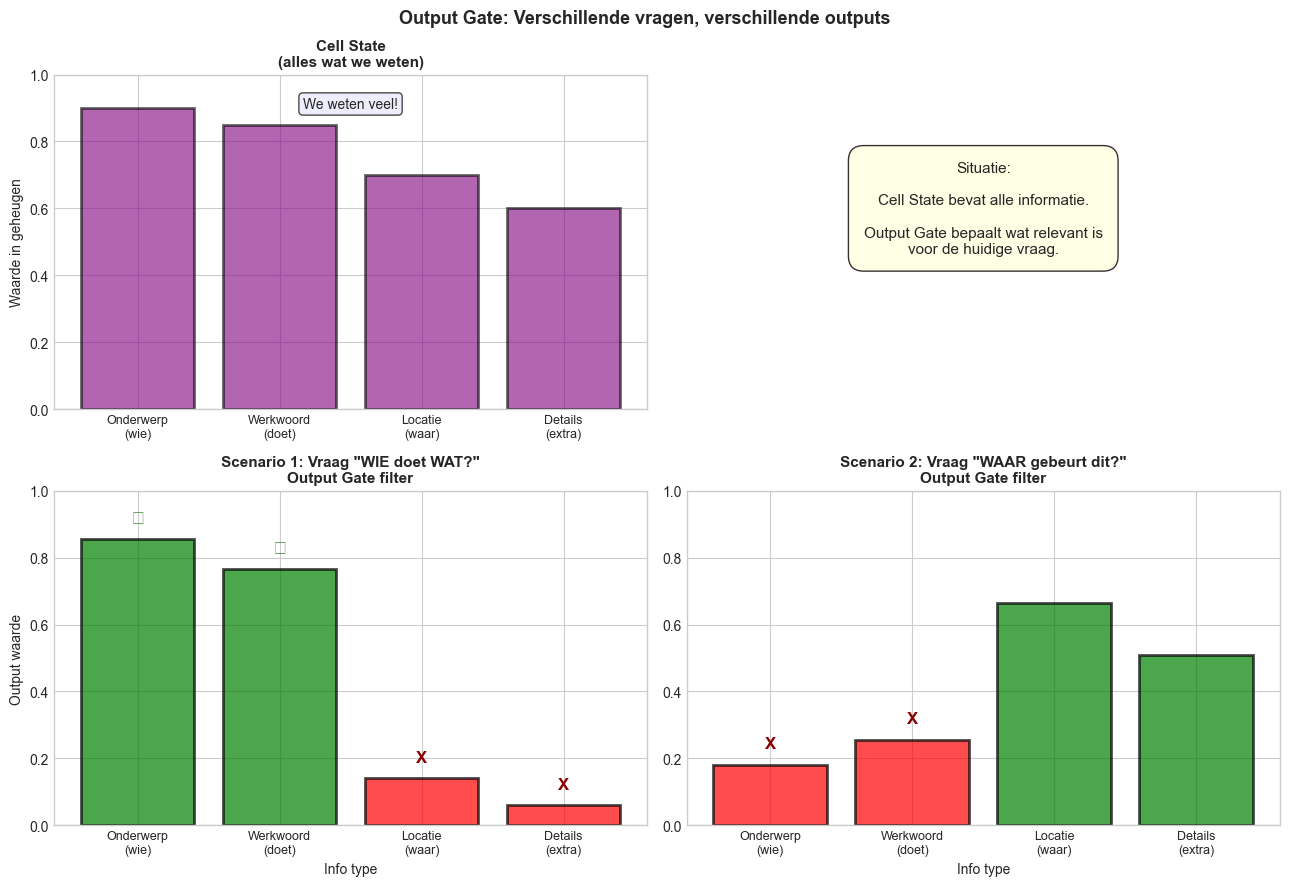


Hetzelfde geheugen, verschillende output:
Vraag 1: 'Wie doet wat?' → Focus op onderwerp en werkwoord
Vraag 2: 'Waar gebeurt dit?' → Focus op locatie en details

De Output Gate past zich aan de situatie aan!


In [5]:
# Visualiseer Output Gate

def toon_output_gate():
    # Scenario: LSTM moet antwoord geven op een vraag
    geheugen_items = ['Onderwerp\n(wie)', 'Werkwoord\n(doet)', 'Locatie\n(waar)', 
                      'Details\n(extra)']
    
    # Alles wat in het geheugen zit
    cell_state = np.array([0.9, 0.85, 0.7, 0.6])
    
    # Twee verschillende situaties:
    scenario_1_gate = np.array([0.95, 0.9, 0.2, 0.1])  # Vraag: "WIE doet WAT?"
    scenario_2_gate = np.array([0.2, 0.3, 0.95, 0.85]) # Vraag: "WAAR gebeurt dit?"
    
    output_1 = cell_state * scenario_1_gate
    output_2 = cell_state * scenario_2_gate
    
    fig, axes = plt.subplots(2, 2, figsize=(13, 9))
    
    x = np.arange(len(geheugen_items))
    
    # Links boven: Cell State (wat we weten)
    axes[0, 0].bar(x, cell_state, color='purple', alpha=0.6, edgecolor='black', linewidth=2)
    axes[0, 0].set_title('Cell State\n(alles wat we weten)', fontweight='bold', fontsize=11)
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(geheugen_items, fontsize=9)
    axes[0, 0].set_ylabel('Waarde in geheugen', fontsize=10)
    axes[0, 0].text(1.5, 0.9, 'We weten veel!', ha='center', fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.7))
    
    # Rechts boven: lege ruimte voor uitleg
    axes[0, 1].axis('off')
    axes[0, 1].text(0.5, 0.6, 'Situatie:\n\nCell State bevat alle informatie.\n\n'
                    'Output Gate bepaalt wat relevant is\nvoor de huidige vraag.',
                    ha='center', va='center', fontsize=11,
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8, pad=1),
                    transform=axes[0, 1].transAxes)
    
    # Links onder: Scenario 1
    colors_1 = ['green' if g > 0.7 else 'orange' if g > 0.3 else 'red' for g in scenario_1_gate]
    axes[1, 0].bar(x, output_1, color=colors_1, alpha=0.7, edgecolor='black', linewidth=2)
    axes[1, 0].set_title('Scenario 1: Vraag "WIE doet WAT?"\nOutput Gate filter', 
                         fontweight='bold', fontsize=11)
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(geheugen_items, fontsize=9)
    axes[1, 0].set_ylabel('Output waarde', fontsize=10)
    axes[1, 0].set_xlabel('Info type', fontsize=10)
    
    for i, val in enumerate(output_1):
        if val > 0.7:
            axes[1, 0].text(i, val + 0.05, '✓', ha='center', fontsize=14, 
                           color='darkgreen', fontweight='bold')
        elif val < 0.3:
            axes[1, 0].text(i, val + 0.05, 'X', ha='center', fontsize=12, 
                           color='darkred', fontweight='bold')
    
    # Rechts onder: Scenario 2
    colors_2 = ['green' if g > 0.7 else 'orange' if g > 0.3 else 'red' for g in scenario_2_gate]
    axes[1, 1].bar(x, output_2, color=colors_2, alpha=0.7, edgecolor='black', linewidth=2)
    axes[1, 1].set_title('Scenario 2: Vraag "WAAR gebeurt dit?"\nOutput Gate filter', 
                         fontweight='bold', fontsize=11)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(geheugen_items, fontsize=9)
    axes[1, 1].set_xlabel('Info type', fontsize=10)
    
    for i, val in enumerate(output_2):
        if val > 0.7:
            axes[1, 1].text(i, val + 0.05, '✓', ha='center', fontsize=14, 
                           color='darkgreen', fontweight='bold')
        elif val < 0.3:
            axes[1, 1].text(i, val + 0.05, 'X', ha='center', fontsize=12, 
                           color='darkred', fontweight='bold')
    
    plt.suptitle('Output Gate: Verschillende vragen, verschillende outputs', 
                 fontsize=13, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print("\nHetzelfde geheugen, verschillende output:")
    print("="*60)
    print("Vraag 1: 'Wie doet wat?' → Focus op onderwerp en werkwoord")
    print("Vraag 2: 'Waar gebeurt dit?' → Focus op locatie en details")
    print("\nDe Output Gate past zich aan de situatie aan!")

toon_output_gate()

## Alles samengebracht: Een complete LSTM-stap

Laten we alle vier de componenten in actie zien bij het lezen van een zin:

**Zin:** "De kat jaagt de muis. De hond slaapt."

We doorlopen wat er gebeurt bij het woord **"hond"**.

SCENARIO: We lezen 'De kat jaagt de muis. De hond slaapt.'
We zijn bij het woord: 'hond'

📚 OUD GEHEUGEN (over de kat):
   Onderwerp: 0.90
   Actie: 0.85
   Object: 0.70
   Context: 0.60

🚪 FORGET GATE (nieuw onderwerp = 'hond'):
   Onderwerp 'kat': vergeten (0.1)
   Actie 'jaagt': vergeten (0.2)
   Object 'muis': vergeten (0.1)
   Context: deels behouden (0.5)

🚪 INPUT GATE (info over 'hond'):
   Onderwerp 'hond': toevoegen (0.95)
   Actie 'slaapt': toevoegen (0.9)
   Object: geen (0.2)
   Context 'rust': toevoegen (0.7)

💾 NIEUW GEHEUGEN:
   Onderwerp: 0.90 → 0.99
   Actie: 0.85 → 0.89
   Object: 0.70 → 0.09
   Context: 0.60 → 0.79

🚪 OUTPUT GATE (wat delen we nu?):
   Focus op onderwerp en actie voor volgende woord
   Output: [0.89325 0.7565  0.027   0.474  ]

RESULTAAT: Het model weet nu dat 'hond' het onderwerp is en 'slaapt' de actie.
Het heeft 'kat jaagt muis' grotendeels vergeten.


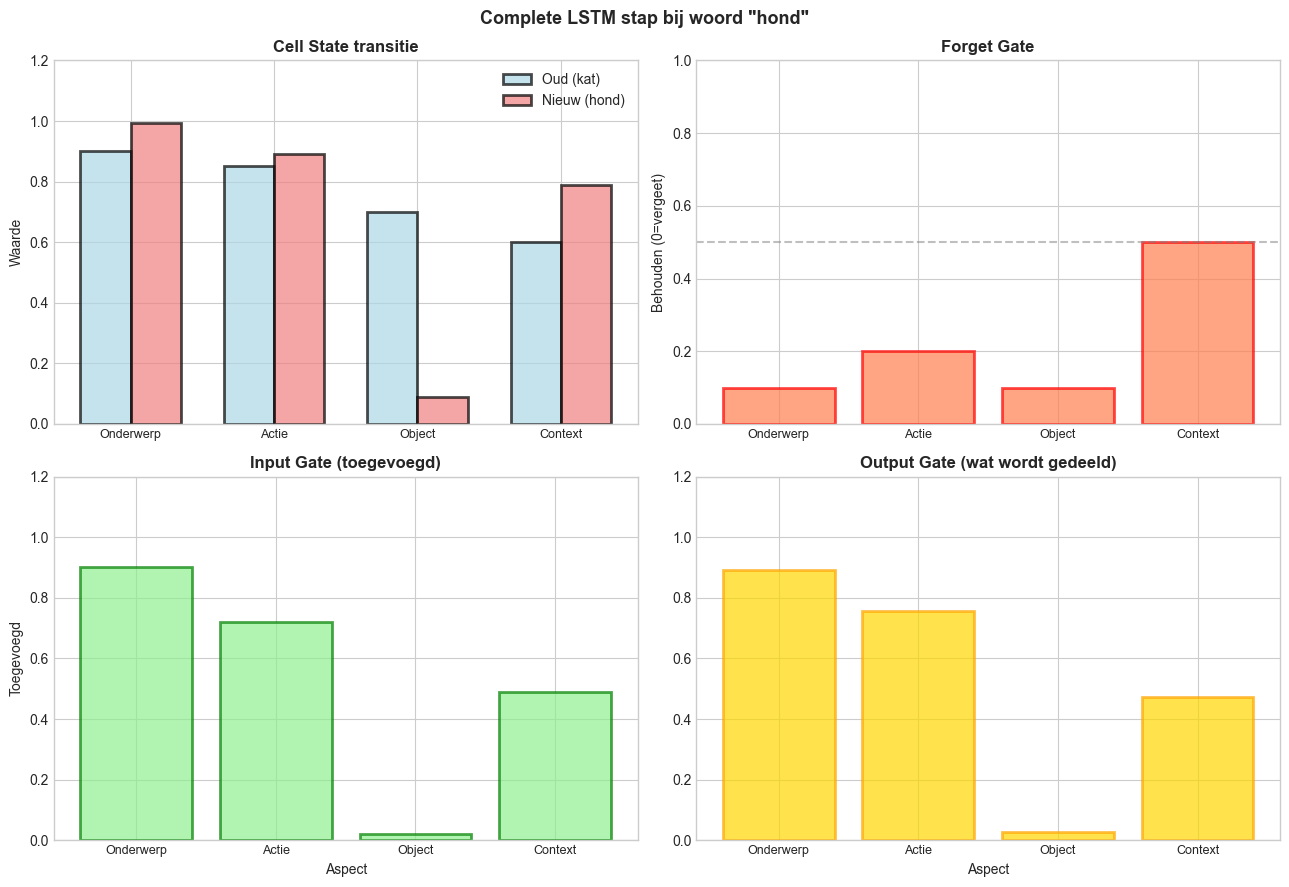

In [6]:
# Complete LSTM stap

def complete_lstm_voorbeeld():
    print("SCENARIO: We lezen 'De kat jaagt de muis. De hond slaapt.'")
    print("We zijn bij het woord: 'hond'\n")
    print("="*70)
    
    aspecten = ['Onderwerp', 'Actie', 'Object', 'Context']
    
    # Oud geheugen (van 'kat jaagt muis')
    oud_geheugen = np.array([0.9, 0.85, 0.7, 0.6])  # kat, jaagt, muis, jacht-context
    print("📚 OUD GEHEUGEN (over de kat):")
    for asp, val in zip(aspecten, oud_geheugen):
        print(f"   {asp}: {val:.2f}")
    
    # Forget gate (nieuw onderwerp!)
    forget = np.array([0.1, 0.2, 0.1, 0.5])  # Vergeet kat, actie, muis; behoud deels context
    behouden = oud_geheugen * forget
    print("\n🚪 FORGET GATE (nieuw onderwerp = 'hond'):")
    print(f"   Onderwerp 'kat': vergeten (0.1)")
    print(f"   Actie 'jaagt': vergeten (0.2)")
    print(f"   Object 'muis': vergeten (0.1)")
    print(f"   Context: deels behouden (0.5)")
    
    # Input gate (nieuwe info over hond)
    nieuwe_info = np.array([0.95, 0.8, 0.1, 0.7])  # hond, slaapt, geen object, rust-context
    input_gate = np.array([0.95, 0.9, 0.2, 0.7])
    toegevoegd = nieuwe_info * input_gate
    print("\n🚪 INPUT GATE (info over 'hond'):")
    print(f"   Onderwerp 'hond': toevoegen (0.95)")
    print(f"   Actie 'slaapt': toevoegen (0.9)")
    print(f"   Object: geen (0.2)")
    print(f"   Context 'rust': toevoegen (0.7)")
    
    # Nieuw geheugen
    nieuw_geheugen = behouden + toegevoegd
    print("\n💾 NIEUW GEHEUGEN:")
    for asp, oud, nw in zip(aspecten, oud_geheugen, nieuw_geheugen):
        print(f"   {asp}: {oud:.2f} → {nw:.2f}")
    
    # Output gate
    output_gate = np.array([0.9, 0.85, 0.3, 0.6])
    output = nieuw_geheugen * output_gate
    print("\n🚪 OUTPUT GATE (wat delen we nu?):")
    print(f"   Focus op onderwerp en actie voor volgende woord")
    print(f"   Output: {output}")
    
    print("\n" + "="*70)
    print("RESULTAAT: Het model weet nu dat 'hond' het onderwerp is en 'slaapt' de actie.")
    print("Het heeft 'kat jaagt muis' grotendeels vergeten.")
    
    # Visualisatie
    fig, axes = plt.subplots(2, 2, figsize=(13, 9))
    x = np.arange(len(aspecten))
    
    # Plot 1: Oud vs Nieuw geheugen
    width = 0.35
    axes[0, 0].bar(x - width/2, oud_geheugen, width, label='Oud (kat)', 
                   color='lightblue', alpha=0.7, edgecolor='black', linewidth=2)
    axes[0, 0].bar(x + width/2, nieuw_geheugen, width, label='Nieuw (hond)', 
                   color='lightcoral', alpha=0.7, edgecolor='black', linewidth=2)
    axes[0, 0].set_title('Cell State transitie', fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(aspecten, fontsize=9)
    axes[0, 0].set_ylabel('Waarde')
    axes[0, 0].legend()
    axes[0, 0].set_ylim(0, 1.2)
    
    # Plot 2: Forget gate
    axes[0, 1].bar(x, forget, color='coral', alpha=0.7, edgecolor='red', linewidth=2)
    axes[0, 1].set_title('Forget Gate', fontweight='bold')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(aspecten, fontsize=9)
    axes[0, 1].set_ylabel('Behouden (0=vergeet)')
    axes[0, 1].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    axes[0, 1].set_ylim(0, 1)
    
    # Plot 3: Input gate
    axes[1, 0].bar(x, toegevoegd, color='lightgreen', alpha=0.7, edgecolor='green', linewidth=2)
    axes[1, 0].set_title('Input Gate (toegevoegd)', fontweight='bold')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(aspecten, fontsize=9)
    axes[1, 0].set_ylabel('Toegevoegd')
    axes[1, 0].set_xlabel('Aspect')
    axes[1, 0].set_ylim(0, 1.2)
    
    # Plot 4: Output
    axes[1, 1].bar(x, output, color='gold', alpha=0.7, edgecolor='orange', linewidth=2)
    axes[1, 1].set_title('Output Gate (wat wordt gedeeld)', fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(aspecten, fontsize=9)
    axes[1, 1].set_xlabel('Aspect')
    axes[1, 1].set_ylim(0, 1.2)
    
    plt.suptitle('Complete LSTM stap bij woord "hond"', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

complete_lstm_voorbeeld()

## Waarom zijn LSTMs zo krachtig?

### 1. Lange-termijn geheugen
LSTMs kunnen informatie honderden stappen onthouden. Perfect voor:
- Lange teksten
- Tijdreeksen (aandelenkoersen over maanden)
- Gesprekken

### 2. Selectief vergeten
Niet alles is belangrijk. LSTMs leren wat wel en niet relevant is:
- Nieuw hoofdstuk? Vergeet de vorige hoofdpersoon
- Nieuwe dag? Vergeet het weer van gisteren

### 3. Slim filteren
De gates werken samen:
- Forget Gate: ruimt op
- Input Gate: voegt toe wat belangrijk is
- Output Gate: deelt alleen wat nu relevant is

### 4. Leert automatisch
Je hoeft niet te programmeren wat belangrijk is - het model leert dit zelf uit data!

## Toepassingen

LSTMs worden gebruikt voor:
- **Tekst generatie** - ChatGPT voorlopers
- **Vertalen** - Google Translate (voordat transformers kwamen)
- **Spraakherkenning** - Siri, Alexa
- **Tijdreeks voorspelling** - Aandelenkoersen, weer
- **Muziek compositie** - Melodieën genereren

## Samenvatting

Een LSTM heeft **4 componenten**:

| Component | Vraag | Analogie |
|-----------|-------|----------|
| **Forget Gate** | Wat mag ik vergeten? | Doorstrepen in je notitieboek |
| **Input Gate** | Wat moet ik onthouden? | Belangrijke dingen opschrijven |
| **Cell State** | Wat is mijn geheugen? | Het notitieboek zelf |
| **Output Gate** | Wat deel ik nu? | Selectief antwoorden in gesprek |

**Kernidee:** LSTMs kunnen lang onthouden én slim vergeten, waardoor ze perfect zijn voor sequenties (tekst, tijdreeksen, spraak).

## Experimenteer zelf!

Probeer verschillende scenario's en zie hoe de gates zich gedragen.

Beschikbare situaties: 'onderwerp_wissel', 'voortzetting', 'tijd_sprong'



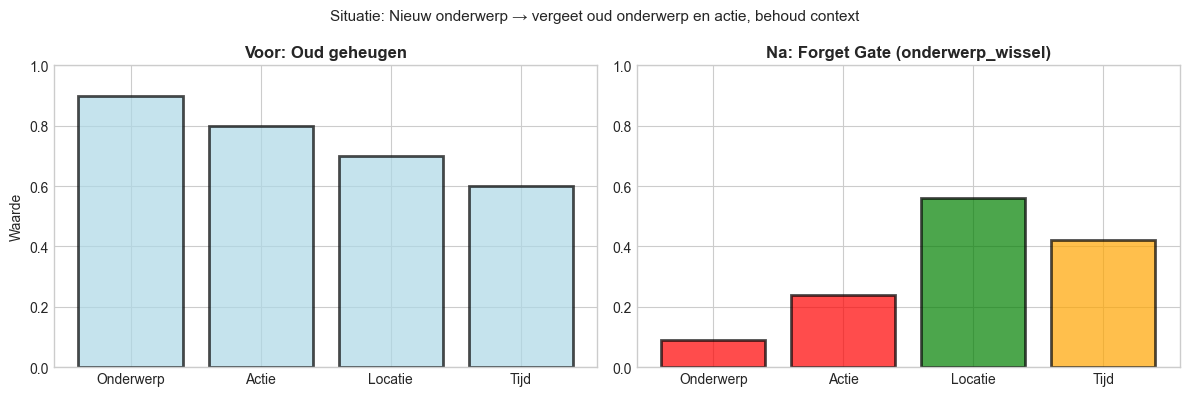


Resultaat:
  Onderwerp: 0.90 → 0.09 (VERGETEN)
  Actie: 0.80 → 0.24 (VERGETEN)
  Locatie: 0.70 → 0.56 (BEHOUDEN)
  Tijd: 0.60 → 0.42 (DEELS)


In [7]:
# EXPERIMENT 1: Simuleer verschillende Forget Gate strategieën

def experimenteer_forget_gate(situatie="onderwerp_wissel"):
    """
    Probeer verschillende situaties:
    - 'onderwerp_wissel': Nieuw onderwerp in de zin
    - 'voortzetting': Hetzelfde onderwerp gaat door
    - 'tijd_sprong': Tijdsprong in het verhaal
    """
    
    geheugen_items = ['Onderwerp', 'Actie', 'Locatie', 'Tijd']
    oud_geheugen = np.array([0.9, 0.8, 0.7, 0.6])
    
    situaties = {
        'onderwerp_wissel': {
            'forget': np.array([0.1, 0.3, 0.8, 0.7]),
            'uitleg': 'Nieuw onderwerp → vergeet oud onderwerp en actie, behoud context'
        },
        'voortzetting': {
            'forget': np.array([0.95, 0.6, 0.9, 0.85]),
            'uitleg': 'Voortzetting → behoud alles, update alleen actie'
        },
        'tijd_sprong': {
            'forget': np.array([0.7, 0.2, 0.5, 0.1]),
            'uitleg': 'Tijdsprong → behoud onderwerp, vergeet tijd en actie'
        }
    }
    
    if situatie not in situaties:
        print(f"Kies: {', '.join(situaties.keys())}")
        return
    
    forget = situaties[situatie]['forget']
    behouden = oud_geheugen * forget
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    x = np.arange(len(geheugen_items))
    
    # Voor en na
    axes[0].bar(x, oud_geheugen, color='lightblue', alpha=0.7, edgecolor='black', linewidth=2)
    axes[0].set_title('Voor: Oud geheugen', fontweight='bold')
    axes[0].set_ylim(0, 1)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(geheugen_items)
    axes[0].set_ylabel('Waarde')
    
    colors = ['green' if f > 0.7 else 'orange' if f > 0.4 else 'red' for f in forget]
    axes[1].bar(x, behouden, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    axes[1].set_title(f'Na: Forget Gate ({situatie})', fontweight='bold')
    axes[1].set_ylim(0, 1)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(geheugen_items)
    
    plt.suptitle(f'Situatie: {situaties[situatie]["uitleg"]}', fontsize=11)
    plt.tight_layout()
    plt.show()
    
    print("\nResultaat:")
    for item, oud, nw, f in zip(geheugen_items, oud_geheugen, behouden, forget):
        status = "BEHOUDEN" if f > 0.7 else "DEELS" if f > 0.3 else "VERGETEN"
        print(f"  {item}: {oud:.2f} → {nw:.2f} ({status})")

# Probeer verschillende situaties!
print("Beschikbare situaties: 'onderwerp_wissel', 'voortzetting', 'tijd_sprong'\n")
experimenteer_forget_gate('onderwerp_wissel')

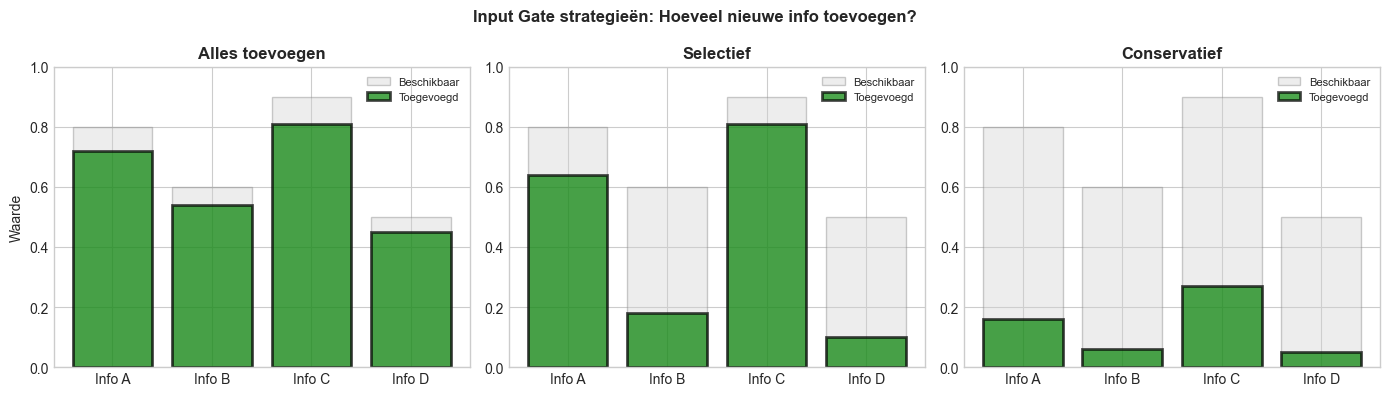


Strategieën:
- Alles toevoegen: Onthoud bijna alles (risico: irrelevante info)
- Selectief: Kies alleen belangrijke info (gebalanceerd)
- Conservatief: Voeg weinig toe (risico: mis belangrijke info)


In [8]:
# EXPERIMENT 2: Vergelijk Input Gate filters

def vergelijk_input_filters():
    nieuwe_info = np.array([0.8, 0.6, 0.9, 0.5])  # Informatie beschikbaar
    info_labels = ['Info A', 'Info B', 'Info C', 'Info D']
    
    # Drie strategieën
    filters = {
        'Alles toevoegen': np.array([0.9, 0.9, 0.9, 0.9]),
        'Selectief': np.array([0.8, 0.3, 0.9, 0.2]),
        'Conservatief': np.array([0.2, 0.1, 0.3, 0.1])
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    x = np.arange(len(info_labels))
    
    for idx, (naam, filter_vals) in enumerate(filters.items()):
        toegevoegd = nieuwe_info * filter_vals
        
        axes[idx].bar(x, nieuwe_info, color='lightgray', alpha=0.4, 
                     label='Beschikbaar', edgecolor='gray', linewidth=1)
        axes[idx].bar(x, toegevoegd, color='green', alpha=0.7, 
                     label='Toegevoegd', edgecolor='black', linewidth=2)
        axes[idx].set_title(naam, fontweight='bold')
        axes[idx].set_ylim(0, 1)
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(info_labels)
        axes[idx].legend(loc='upper right', fontsize=8)
        if idx == 0:
            axes[idx].set_ylabel('Waarde')
    
    plt.suptitle('Input Gate strategieën: Hoeveel nieuwe info toevoegen?', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nStrategieën:")
    print("- Alles toevoegen: Onthoud bijna alles (risico: irrelevante info)")
    print("- Selectief: Kies alleen belangrijke info (gebalanceerd)")
    print("- Conservatief: Voeg weinig toe (risico: mis belangrijke info)")

vergelijk_input_filters()

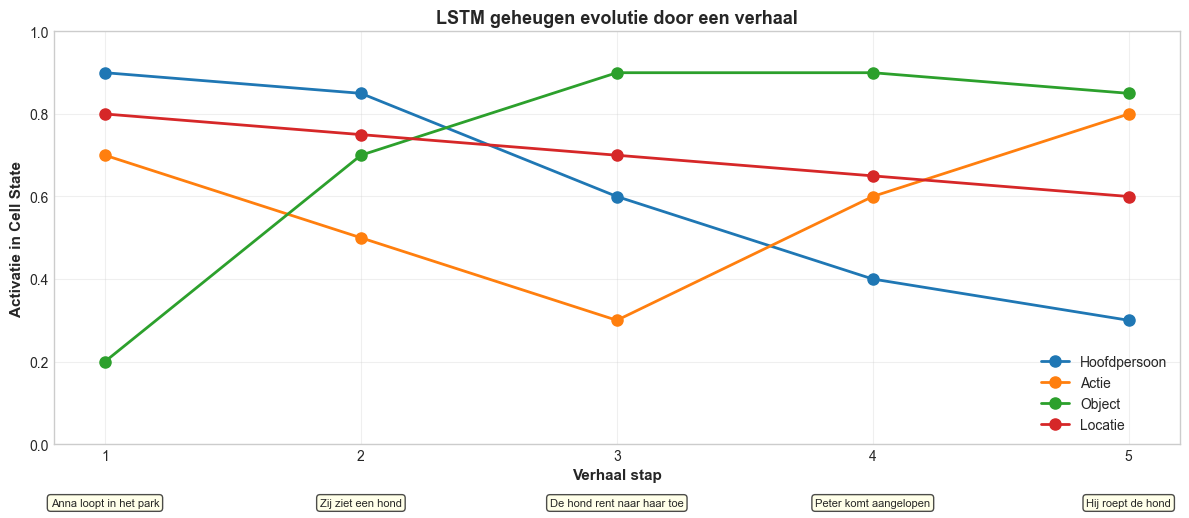


Observaties:
- Hoofdpersoon: Anna hoog → daalt wanneer Peter komt
- Object (hond): stijgt en blijft belangrijk
- Locatie (park): blijft relatief stabiel als context
- Actie: varieert per stap

Dit laat zien hoe LSTM selectief onthoudt en vergeet!


In [9]:
# EXPERIMENT 3: Simuleer een verhaal over meerdere stappen

def simuleer_verhaal():
    """
    Simuleer hoe LSTM geheugen evolueert door een kort verhaal.
    """
    
    verhaal_stappen = [
        "Anna loopt in het park",
        "Zij ziet een hond",
        "De hond rent naar haar toe",
        "Peter komt aangelopen",
        "Hij roept de hond"
    ]
    
    # Simuleer cell state door de tijd (4 neuronen)
    # Neuron 0: Hoofdpersoon info
    # Neuron 1: Actie info  
    # Neuron 2: Object/Andere persoon
    # Neuron 3: Locatie/Context
    
    cell_states = [
        np.array([0.9, 0.7, 0.2, 0.8]),   # Stap 1: Anna, loopt, -, park
        np.array([0.85, 0.5, 0.7, 0.75]), # Stap 2: Anna, ziet, hond, park
        np.array([0.6, 0.3, 0.9, 0.7]),   # Stap 3: (Anna), -, hond rent!, park
        np.array([0.4, 0.6, 0.9, 0.65]),  # Stap 4: Peter!, komt, hond, park
        np.array([0.3, 0.8, 0.85, 0.6])   # Stap 5: Peter, roept, hond, park
    ]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    neuronen = ['Hoofdpersoon', 'Actie', 'Object', 'Locatie']
    x = np.arange(len(verhaal_stappen))
    
    for i, neuron_naam in enumerate(neuronen):
        waarden = [state[i] for state in cell_states]
        ax.plot(x, waarden, marker='o', linewidth=2, markersize=8, label=neuron_naam)
    
    ax.set_xlabel('Verhaal stap', fontsize=11, fontweight='bold')
    ax.set_ylabel('Activatie in Cell State', fontsize=11, fontweight='bold')
    ax.set_title('LSTM geheugen evolutie door een verhaal', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{i+1}" for i in range(len(verhaal_stappen))], fontsize=10)
    ax.set_ylim(0, 1)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Voeg verhaal stappen toe als annotaties
    for i, stap in enumerate(verhaal_stappen):
        ax.text(i, -0.15, stap, ha='center', fontsize=8, rotation=0,
               bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()
    
    print("\nObservaties:")
    print("- Hoofdpersoon: Anna hoog → daalt wanneer Peter komt")
    print("- Object (hond): stijgt en blijft belangrijk")
    print("- Locatie (park): blijft relatief stabiel als context")
    print("- Actie: varieert per stap")
    print("\nDit laat zien hoe LSTM selectief onthoudt en vergeet!")

simuleer_verhaal()

Maak je eigen LSTM scenario!

Pas de variabelen hieronder aan en voer opnieuw uit:



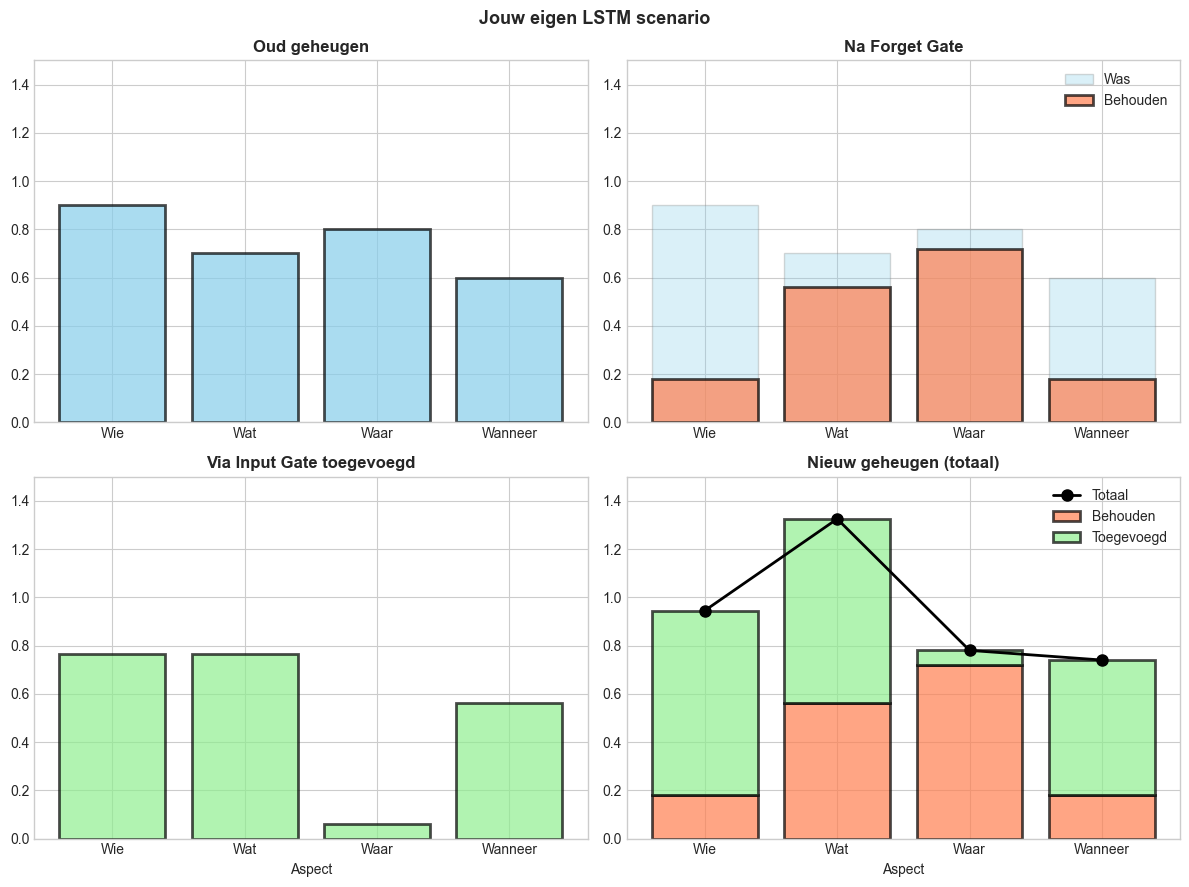


Resultaten per aspect:
Wie:
  Oud: 0.90 → Behouden: 0.18 + Toegevoegd: 0.77 = Nieuw: 0.95
Wat:
  Oud: 0.70 → Behouden: 0.56 + Toegevoegd: 0.77 = Nieuw: 1.32
Waar:
  Oud: 0.80 → Behouden: 0.72 + Toegevoegd: 0.06 = Nieuw: 0.78
Wanneer:
  Oud: 0.60 → Behouden: 0.18 + Toegevoegd: 0.56 = Nieuw: 0.74


In [ ]:
# EXPERIMENT 4: Maak je eigen LSTM scenario

def maak_eigen_scenario():
    print("Maak je eigen LSTM scenario!\n")
    print("Pas de variabelen hieronder aan en voer opnieuw uit:\n")
    
    # PAS DEZE AAN!
    geheugen_aspecten = ['Wie', 'Wat', 'Waar', 'Wanneer']
    oud_geheugen_waarden = [0.9, 0.7, 0.8, 0.6]  # Wat zat er in het geheugen?
    forget_waarden = [0.2, 0.8, 0.9, 0.3]        # Hoeveel behouden? (0=vergeet, 1=behoud)
    nieuwe_info_waarden = [0.85, 0.9, 0.3, 0.8]  # Nieuwe informatie
    input_gate_waarden = [0.9, 0.85, 0.2, 0.7]   # Hoeveel toevoegen?
    
    # Bereken
    oud = np.array(oud_geheugen_waarden)
    forget = np.array(forget_waarden)
    nieuw_info = np.array(nieuwe_info_waarden)
    inp_gate = np.array(input_gate_waarden)
    
    behouden = oud * forget
    toegevoegd = nieuw_info * inp_gate
    nieuw_geheugen = behouden + toegevoegd
    
    # Visualiseer
    fig, axes = plt.subplots(2, 2, figsize=(12, 9))
    x = np.arange(len(geheugen_aspecten))
    
    # Oud geheugen
    axes[0, 0].bar(x, oud, color='skyblue', alpha=0.7, edgecolor='black', linewidth=2)
    axes[0, 0].set_title('Oud geheugen', fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(geheugen_aspecten)
    axes[0, 0].set_ylim(0, 1.5)
    
    # Forget gate effect
    axes[0, 1].bar(x, oud, color='skyblue', alpha=0.3, label='Was', edgecolor='gray')
    axes[0, 1].bar(x, behouden, color='coral', alpha=0.7, label='Behouden', edgecolor='black', linewidth=2)
    axes[0, 1].set_title('Na Forget Gate', fontweight='bold')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(geheugen_aspecten)
    axes[0, 1].set_ylim(0, 1.5)
    axes[0, 1].legend()
    
    # Input gate toevoeging
    axes[1, 0].bar(x, toegevoegd, color='lightgreen', alpha=0.7, edgecolor='black', linewidth=2)
    axes[1, 0].set_title('Via Input Gate toegevoegd', fontweight='bold')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(geheugen_aspecten)
    axes[1, 0].set_ylim(0, 1.5)
    axes[1, 0].set_xlabel('Aspect')
    
    # Nieuw geheugen
    axes[1, 1].bar(x, behouden, color='coral', alpha=0.7, label='Behouden', edgecolor='black', linewidth=2)
    axes[1, 1].bar(x, toegevoegd, bottom=behouden, color='lightgreen', alpha=0.7, 
                   label='Toegevoegd', edgecolor='black', linewidth=2)
    axes[1, 1].plot(x, nieuw_geheugen, 'ko-', linewidth=2, markersize=8, label='Totaal')
    axes[1, 1].set_title('Nieuw geheugen (totaal)', fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(geheugen_aspecten)
    axes[1, 1].set_ylim(0, 1.5)
    axes[1, 1].set_xlabel('Aspect')
    axes[1, 1].legend()
    
    plt.suptitle('Jouw eigen LSTM scenario', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nResultaten per aspect:")
    print("="*60)
    for asp, o, b, t, n in zip(geheugen_aspecten, oud, behouden, toegevoegd, nieuw_geheugen):
        print(f"{asp}:")
        print(f"  Oud: {o:.2f} → Behouden: {b:.2f} + Toegevoegd: {t:.2f} = Nieuw: {n:.2f}")

maak_eigen_scenario()

## Conclusie

Je hebt nu geleerd:

✓ Waarom LSTMs nodig zijn (normaal netwerk heeft geen geheugen)  
✓ Hoe de **Forget Gate** besluit wat te vergeten  
✓ Hoe de **Input Gate** besluit wat toe te voegen  
✓ Hoe de **Cell State** wordt geüpdatet  
✓ Hoe de **Output Gate** bepaalt wat gedeeld wordt  
✓ Hoe alle componenten samenwerken  

**Het kernidee:** LSTMs zijn als een slim notitieboek dat:
- Automatisch belangrijke dingen onthoudt
- Automatisch onbelangrijke dingen vergeet
- Weet wat relevant is om te delen

Dit maakt ze perfect voor taken met **sequenties**: tekst, spraak, tijdreeksen, en meer!

---

**Volgende stap:** Speel met de experimenten hierboven om je intuïtie te versterken!